In [18]:
from tensorflow import keras
from keras import layers
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import json

In [31]:

DATADIR = "data/english"
GLOVE_BASE_DIR = "data/"

params = {
    'dim_chars': 100,
    'dim': 300,
    'dropout': 0.5,
    'epochs': 25,
    'batch_size': 20,
    'filters': 30,
    'kernel_size': 3,
    'lstm_size': 200,
    'optimizer': 'adam',
    'metrics': ['acc'],
#     'loss': "categorical_crossentropy",
    'loss': keras.losses.CategoricalCrossentropy(from_logits=True),
    'model_path': str(Path(DATADIR, 'model.h5')),
    'model_cnn_bilstm_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_crf.h5')),
    'model_cnn_bilstm_dn_crf_path': str(Path(DATADIR, 'model_cnn_bilstm_dn_crf.h5')),
    'model_bilstm_crf_path': str(Path(DATADIR, 'model_bilstm_crf.h5')),
    'model_bilstm_dn_crf_path': str(Path(DATADIR, 'model_bilstm_dn_crf.h5')),
    'model_histories_path': str(Path(DATADIR)),
    'words_path': str(Path(DATADIR, 'vocab.words.txt')),
    'chars_path': str(Path(DATADIR, 'vocab.chars.txt')),
    'tags_path': str(Path(DATADIR, 'vocab.tags.txt')),
    'sentences_path': (str(Path(DATADIR, 'train.words.txt')), str(Path(DATADIR, 'testa.words.txt')), str(Path(DATADIR, 'testb.words.txt'))),
    'labels_path': (str(Path(DATADIR, 'train.tags.txt')), str(Path(DATADIR, 'testa.tags.txt')), str(Path(DATADIR, 'testb.tags.txt'))),
    'glove_path': str(Path(DATADIR, 'glove.npz')),
    'glove_raw_path': str(Path(GLOVE_BASE_DIR, 'glove.840B.300d.txt')),
    'char_vectorization_path': str(Path(DATADIR, 'char_vectorization.npz'))
}

In [32]:
def load_processed_files(params: dict):
    # Loading preprocessed files

    # Load vocab
    with Path(params["words_path"]).open() as f:
        word_to_idx = {}
        idx_to_word = {}
        for idx, line in enumerate(f):
            word = line.strip()
            word_to_idx[word] = idx
            idx_to_word[idx] = word

    size_vocab = len(word_to_idx)
    params['vocab_size'] = size_vocab
    print("vocab_size", size_vocab)

    # Load chars
    with Path(params["chars_path"]).open() as f:
        char_to_idx = {}
        idx_to_char = []
        for idx, line in enumerate(f):
            char = line.strip()
            char_to_idx[char] = idx
            idx_to_char.append(char)

    size_chars = len(char_to_idx)
    print("Char amount", size_chars)
    params['char_amount'] = size_chars
    params['chars'] = idx_to_char

    # Load tags
    with Path(params["tags_path"]).open() as f:
        tag_to_idx = {}
        idx_to_tag = {}
        for idx, line in enumerate(f):
            tag = line.strip()
            tag_to_idx[tag] = idx
            idx_to_tag[idx] = tag
    size_tags = len(tag_to_idx)
    print("Tag amount", size_tags)
    params['tag_amount'] = size_tags


    max_sent_size = 0
    max_word_size = 0

    for path in params["sentences_path"]:
        with Path(path).open() as f:
            for sentence in f:
                sentence = sentence.split(' ')
                for word in sentence:
                    max_word_size = max(max_word_size, len(word))
                max_sent_size = max(max_sent_size, len(sentence))

    print("Max word size", max_word_size)
    print("Max sentence size", max_sent_size)

    params['max_sent_size'] = max_sent_size
    params['max_word_size'] = max_word_size

load_processed_files(params)

vocab_size 8418
Char amount 83
Tag amount 10
Max word size 18
Max sentence size 73


In [33]:

def load_dataset_string(params:dict):
    # Loading dataset

    train_sentences = [x for x in Path(params['sentences_path'][0]).read_text().splitlines()]
    testa_sentences = [x for x in Path(params['sentences_path'][1]).read_text().splitlines()]
    testb_sentences = [x for x in Path(params['sentences_path'][2]).read_text().splitlines()]

    train_labels = [x.strip() for x in Path(params['labels_path'][0]).read_text().splitlines()]
    testa_labels = [x.strip() for x in Path(params['labels_path'][1]).read_text().splitlines()]
    testb_labels = [x.strip() for x in Path(params['labels_path'][2]).read_text().splitlines()]

    params['train_sentences'] = train_sentences
    params['testa_sentences'] = testa_sentences
    params['testb_sentences'] = testb_sentences
    
    params['train_labels'] = train_labels
    params['testa_labels'] = testa_labels
    params['testb_labels'] = testb_labels
    
load_dataset_string(params)

In [34]:

def add_vectorizers(params: dict):
    
    # Sentence vectorizer
    vectorizer = layers.TextVectorization(
        max_tokens=params["vocab_size"], 
        output_sequence_length=params["max_sent_size"]
    )
    
    train_sentences = params['train_sentences']
    testa_sentences = params['testa_sentences']
    testb_sentences = params['testb_sentences']
    
    text_ds = tf.data.Dataset.from_tensor_slices(train_sentences + testa_sentences + testb_sentences).batch(params["batch_size"])
    vectorizer.adapt(text_ds)
    params['vectorizer_sentence'] = vectorizer

    # Tags vectorizer
    vectorizer_tags = layers.TextVectorization(
        max_tokens=params["tag_amount"],
        output_sequence_length=params["max_sent_size"]
    )
    
    train_labels = params['train_labels']
    testa_labels = params['testa_labels']
    testb_labels = params['testb_labels']
    
    tags_ds = tf.data.Dataset.from_tensor_slices(train_labels + testa_labels + testb_labels).batch(params["batch_size"])
    vectorizer_tags.adapt(tags_ds)
    
    params['vectorizer_tags'] = vectorizer_tags
    
    
    # Char vectorizer
    vectorizer_chars = layers.TextVectorization(
        max_tokens=params["char_amount"],
        output_sequence_length=params["max_word_size"]
    )
    
    chars = params['chars']
    
    vectorizer_chars.adapt(chars)
    
    params['vectorizer_chars'] = vectorizer_chars
    
    
    # Checking vectorizer

    # 0 -> Padding
    # 1 -> Out Of Vocabulary

    output = vectorizer([["los atletas les pagan en exceso"]])
    print(output.numpy()[0, :6])

    output = vectorizer([["ascas atletas"]])
    print(output.numpy()[0, :])

    output = vectorizer_tags([["O O a B-Claim I-Claim"]])
    print(output.numpy()[0, :6])

    output = vectorizer_tags([["ascas atletas"]])
    print(output.numpy()[0, :])
    
    output = vectorizer_chars([["asv v d s"]])
    print(output.numpy()[0, :6])

    output = vectorizer_chars([["/ 3 & 6"]])
    print(output.numpy()[0, :])
    
    
    
add_vectorizers(params)

[   1    1 6032    1    1    1]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[3 3 1 9 4 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1  6 24  9  0  0]
[40 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [35]:

def add_word_to_index(params: dict):
    vectorizer = params["vectorizer_sentence"]
    
    # Index to word and Word to index
    
    # Sentences
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    params["words"] = voc
    params["word_index"] = word_index

    print("Vocab size", len(voc))
    print(params['words'][:10])
    params['vocab_size'] = len(voc) - 2 # Minus PAD and UNK
    
    # Tags
    vectorizer_tags = params["vectorizer_tags"]
    tags = vectorizer_tags.get_vocabulary()
    tag_index = dict(zip(tags, range(len(tags))))
    params["tags"] = tags
    params["tag_index"] = tag_index

    print("Tag amount", len(tags))
    print(params['tags'])
    params['tag_amount'] = len(tags) - 2 # Minus PAD and UNK

    # Chars
    vectorizer_chars = params["vectorizer_chars"]
    chars = vectorizer_chars.get_vocabulary()
    char_index = dict(zip(chars, range(len(chars))))
    params["chars"] = chars
    params["char_index"] = char_index

    print("Char amount", len(chars))
    print(params['chars'])
    params['char_amount'] = len(chars) - 2 # Minus PAD and UNK

add_word_to_index(params)


Vocab size 7639
['', '[UNK]', 'the', 'to', 'of', 'and', 'in', 'a', 'is', 'that']
Tag amount 10
['', '[UNK]', 'ipremise', 'o', 'iclaim', 'imajorclaim', 'epremise', 'bpremise', 'eclaim', 'bclaim']
Char amount 44
['', '[UNK]', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '”', '“', '’', '‘', '–', 'é', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']


In [36]:


def loading_glove(params: dict):
    
    if Path(params["glove_path"]).exists():
        print("Glove Embedding Matrix Found")
        embedding_matrix = np.load(params["glove_path"])["embeddings"]
        params['embedding_matrix'] = embedding_matrix
        return
    
    # Loading Glove
    hits = 0
    misses = 0
    num_tokens = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    size_vocab = params['vocab_size']
    word_index = params['word_index']

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    with Path(params["glove_raw_path"]).open() as f:
        for line_idx, line in enumerate(f):
            if line_idx % 100000 == 0:
                print('- At line {}'.format(line_idx))
            line = line.strip().split()
            if len(line) != 300 + 1:
                continue
            word = line[0]
            embedding = line[1:]
            if word in word_index:
                hits += 1
                word_idx = word_index[word]
                embedding_matrix[word_idx] = embedding
    print('- done. Found {} vectors for {} words'.format(hits, size_vocab))
    
    params['embedding_matrix'] = embedding_matrix
    np.savez_compressed(params["glove_path"], embeddings=embedding_matrix)

loading_glove(params)


Glove Embedding Matrix Found


In [37]:

def convert_dataset_to_trainable_data(params: dict):
    
    # Sentences
    
    train_sentences = params['train_sentences']
    testa_sentences = params['testa_sentences']
    testb_sentences = params['testb_sentences']

    vectorizer = params['vectorizer_sentence']
    
    x_train = vectorizer(np.array([[s] for s in train_sentences])).numpy()
    x_test = vectorizer(np.array([[s] for s in testa_sentences])).numpy()
    x_val = vectorizer(np.array([[s] for s in testb_sentences])).numpy()

    params['x_train'] = x_train
    params['x_test'] = x_test
    params['x_val'] = x_val
    
    # Tags
    
    encoder = tf.keras.layers.CategoryEncoding(
        num_tokens= len(params['tags']), # Plus padding, unk
        output_mode="one_hot"
    )
    
    params["tag_encoder"] = encoder
        
    train_labels = params['train_labels']
    testa_labels = params['testa_labels']
    testb_labels = params['testb_labels']
    
    vectorizer_tags = params['vectorizer_tags']
    
    y_train = vectorizer_tags(np.array([x for x in train_labels])).numpy()
    y_test = vectorizer_tags(np.array([x for x in testa_labels])).numpy()
    y_val = vectorizer_tags(np.array([x for x in testb_labels])).numpy()

    y_train = np.array([encoder(x) for x in y_train])
    y_test = np.array([encoder(x) for x in y_test])
    y_val = np.array([encoder(x) for x in y_val])
    
    params["y_train"] = y_train
    params["y_test"] = y_test
    params["y_val"] = y_val
    
    
    # Chars
    
    char_vectorization_path = params["char_vectorization_path"]
    
    if Path(char_vectorization_path).exists():
        array_lists = np.load(char_vectorization_path)
        x_train_char = array_lists["train"]
        params['x_train_char'] = array_lists["train"]
        params['x_test_char'] = array_lists["test"]
        params['x_val_char'] = array_lists["val"]
    else:
        vectorizer_chars = params["vectorizer_chars"]
        max_sent_size = params["max_sent_size"]
        def vetorize_char_sentence(sentence):
            words = sentence.split(" ")
            word_padding = max_sent_size - len(words) 
            return vectorizer_chars([" ".join(word) for word in words] + ["" for _ in range(word_padding)])

        x_train_char = np.array(
            [vetorize_char_sentence(sentence) for sentence in train_sentences])
        x_test_char = np.array(
            [vetorize_char_sentence(sentence) for sentence in testa_sentences])
        x_val_char = np.array(
            [vetorize_char_sentence(sentence) for sentence in testb_sentences])

        params['x_train_char'] = x_train_char
        params['x_test_char'] = x_test_char
        params['x_val_char'] = x_val_char

        np.savez_compressed(char_vectorization_path, train=x_train_char, test=x_test_char, val=x_val_char)
    

    print(x_train.shape)
    print(x_train_char.shape)
    print(y_train.shape)
    print(x_train[0])
    print(x_train_char[0])
    print(y_train[0])

convert_dataset_to_trainable_data(params)


(5096, 73)
(5096, 73, 18)
(5096, 73, 10)
[  28   30   15  701    3 2425   26    3 1562    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[[ 9 20 13 ...  0  0  0]
 [ 9  8  7 ...  0  0  0]
 [26 23  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

In [38]:

def create_model_bilstm_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    loss = params['loss']

    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)

    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(embedded_sequences)

    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # CRF Layer
    crf = tfa.layers.CRF(tag_amount)
    decoded_sequence, potentials, sequence_length, chain_kernel = crf(model_layers)

    # Model
    model = keras.Model(int_sequences_input, potentials)
    model.compile(
        loss=loss, 
        optimizer=optimizer, 
        metrics=metrics)
    model.summary()
    
    params["model"] = model
    params["model_bilstm_crf"] = model

create_model_bilstm_crf(params)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 73)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 73, 300)           2291700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 73, 400)          801600    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 73, 400)           0         
                                                                 
 crf_4 (CRF)                 [(None, 73),              4130      
                              (None, 73, 10),                    
                              (None,),                           
                              (10, 10)]                    

In [39]:

def create_model_bilstm_dn_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    loss = params['loss']

    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)

    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(embedded_sequences)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers) # TODO This layer isn't in the original model
   
    # Dense layer
    model_layers = layers.TimeDistributed(layers.Dense(50))(model_layers) # TODO This layer isn't in the original model
    
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # CRF Layer
    crf = tfa.layers.CRF(tag_amount)
    decoded_sequence, potentials, sequence_length, chain_kernel = crf(model_layers)

    # Model
    model = keras.Model(int_sequences_input, potentials)
    model.compile(
        loss=loss,
        optimizer=optimizer, 
        metrics=metrics)
    model.summary()
    
    params["model"] = model
    params["model_bilstm_dn_crf"] = model

create_model_bilstm_dn_crf(params)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 73)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 73, 300)           2291700   
                                                                 
 bidirectional_5 (Bidirectio  (None, 73, 400)          801600    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 73, 400)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 73, 50)           20050     
 tributed)                                                       
                                                                 
 dropout_8 (Dropout)         (None, 73, 50)            0   

In [47]:

def train_and_save_model_no_cnn(params: dict, model_name='model'):
    
    epochs = params['epochs']
    batch_size = params['batch_size']
    model = params[model_name]
    x_train, y_train = params['x_train'], params['y_train']
    x_val, y_val = params['x_val'], params['y_val']
    
    history = model.fit(x_train, y_train, 
              batch_size=params["batch_size"], 
              epochs=params['epochs'], 
              validation_data=(x_val, y_val))
    
    model.save(params[f"{model_name}_path"])
    with Path(params['model_histories_path'], f"{model_name}_history.json").open('w') as f:
        json.dump(history.history, f)
    

model_name = "model_bilstm_crf"
train_and_save_model_no_cnn(params, model_name)

model_name = "model_bilstm_dn_crf"
train_and_save_model_no_cnn(params, model_name)


Epoch 1/25
255/255 [==============================] - 70s 273ms/step - loss: 0.0339 - acc: 0.9885 - val_loss: 0.6312 - val_acc: 0.8853
Epoch 2/25
255/255 [==============================] - 83s 324ms/step - loss: 0.0354 - acc: 0.9882 - val_loss: 0.6616 - val_acc: 0.8829
Epoch 3/25
255/255 [==============================] - 82s 321ms/step - loss: 0.0321 - acc: 0.9897 - val_loss: 0.6243 - val_acc: 0.8851
Epoch 4/25
255/255 [==============================] - 89s 351ms/step - loss: 0.0272 - acc: 0.9910 - val_loss: 0.7028 - val_acc: 0.8841
Epoch 5/25
255/255 [==============================] - 82s 322ms/step - loss: 0.0227 - acc: 0.9926 - val_loss: 0.7258 - val_acc: 0.8834
Epoch 6/25
255/255 [==============================] - 85s 332ms/step - loss: 0.0164 - acc: 0.9948 - val_loss: 0.7590 - val_acc: 0.8881
Epoch 7/25
255/255 [==============================] - 85s 333ms/step - loss: 0.0144 - acc: 0.9956 - val_loss: 0.7834 - val_acc: 0.8827
Epoch 8/25
255/255 [==============================] - 8

In [48]:
    
def evaluate_model_no_cnn(params: dict, model_name='model'):
    batch_size = params['batch_size']
    model = params[model_name]
    x_test, y_test = params['x_test'], params['y_test']
    
    results = model.evaluate(x_test, y_test, batch_size=batch_size)
    print("test loss, test acc", results)

model_name = "model_bilstm_dn_crf"
evaluate_model_no_cnn(params, model_name)

model_name = "model_bilstm_crf"
evaluate_model_no_cnn(params, model_name)
    

73/73 [==============================] - 6s 78ms/step - loss: 0.7424 - acc: 0.8868
test loss, test acc [0.7424211502075195, 0.8867881894111633]
73/73 [==============================] - 5s 74ms/step - loss: 0.8415 - acc: 0.8923
test loss, test acc [0.8414615392684937, 0.8923355340957642]


In [52]:

def create_model_cnn_bilstm_dn_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    loss = params["loss"]
    
    dim_chars = params["dim_chars"]
    filters = params['filters']
    kernel_size = params["kernel_size"]
    max_word_size = params['max_word_size']
    batch_size = params['batch_size']
    char_index = params['char_index']
    chars = params['chars']
    char_amount = len(chars) # Plus padding and unknown
    
    # Input layer char
    int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")
    
    # Embedding layer char
    embedding_char_layer = layers.Embedding(
        char_amount,
        dim_chars,
        trainable=True,
        input_length=max_word_size
    )
    
    embedded_chars = embedding_char_layer(int_char_input)
    
    # Dropout layer char
    model_char_layers = layers.Dropout(dropout)(embedded_chars)
   
    # Convolution Layer char
    
    model_char_layers = layers.Conv1D(
        filters,
        kernel_size,
        padding="same",
        input_shape=(max_word_size, dim_chars)
    )(model_char_layers)
    
    # Max Polling layer char

    model_char_layers = layers.MaxPooling1D(
        max_word_size,
        input_shape=(max_word_size, filters)
    )(model_char_layers)
    
    # Reshape layer char
    
    model_char_layers = layers.Reshape((filters,), input_shape=(1, filters))(model_char_layers)
    
    char_model = keras.Model(int_char_input, model_char_layers)
    
    char_model.summary()
    
    # Time Distributed with words
    inputs_word_chars = keras.Input(shape=(max_sentence_size, max_word_size), dtype="int64")
    model_char_layers = layers.TimeDistributed(char_model)(inputs_word_chars)
    
    # Dropout layer
    model_char_layers = layers.Dropout(dropout)(model_char_layers)
   
    
    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)
    
    # Concatenate char embedding with sentence embedding
    model_layers = layers.Concatenate()([embedded_sequences, model_char_layers])
    
    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(model_layers)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers) # TODO This layer isn't in the original model
   
    # Dense layer
    model_layers = layers.TimeDistributed(layers.Dense(50))(model_layers) # TODO This layer isn't in the original model

    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # CRF Layer
    crf = tfa.layers.CRF(tag_amount)
    decoded_sequence, potentials, sequence_length, chain_kernel = crf(model_layers)

    # Model
    model = keras.Model([int_sequences_input, inputs_word_chars], potentials)
    model.compile(
        loss=loss,
        optimizer=optimizer, 
        metrics=metrics)
    model.summary()
    
    params["model"] = model
    params["model_cnn_bilstm_dn_crf"] = model

create_model_cnn_bilstm_dn_crf(params)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 18)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 18, 100)           4400      
                                                                 
 dropout_12 (Dropout)        (None, 18, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 30)            9030      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 30)            0         
 1D)                                                             
                                                                 
 reshape_1 (Reshape)         (None, 30)                0         
                                                           

In [50]:

def create_model_cnn_bilstm_crf(params: dict):

    words_amount = len(params['words']) # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sentence_size = params['max_sent_size']
    lstm_size = params["lstm_size"]
    tag_amount = len(params['tags']) # Plus padding and unknown 
    optimizer = params['optimizer']
    metrics = params['metrics']
    dropout = params['dropout']
    loss = params["loss"]
    
    dim_chars = params["dim_chars"]
    filters = params['filters']
    kernel_size = params["kernel_size"]
    max_word_size = params['max_word_size']
    batch_size = params['batch_size']
    char_index = params['char_index']
    chars = params['chars']
    char_amount = len(chars) # Plus padding and unknown
    
    # Input layer char
    int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")
    
    # Embedding layer char
    embedding_char_layer = layers.Embedding(
        char_amount,
        dim_chars,
        trainable=True,
        input_length=max_word_size
    )
    
    embedded_chars = embedding_char_layer(int_char_input)
    
    # Dropout layer char
    model_char_layers = layers.Dropout(dropout)(embedded_chars)
   
    # Convolution Layer char
    
    model_char_layers = layers.Conv1D(
        filters,
        kernel_size,
        padding="same",
        input_shape=(max_word_size, dim_chars)
    )(model_char_layers)
    
    # Max Polling layer char

    model_char_layers = layers.MaxPooling1D(
        max_word_size,
        input_shape=(max_word_size, filters)
    )(model_char_layers)
    
    # Reshape layer char
    
    model_char_layers = layers.Reshape((filters,), input_shape=(1, filters))(model_char_layers)
    
    char_model = keras.Model(int_char_input, model_char_layers)
    
    char_model.summary()
    
    # Time Distributed with words
    inputs_word_chars = keras.Input(shape=(max_sentence_size, max_word_size), dtype="int64")
    model_char_layers = layers.TimeDistributed(char_model)(inputs_word_chars)
    
    # Dropout layer
    model_char_layers = layers.Dropout(dropout)(model_char_layers)
   
    
    # Input layer
    int_sequences_input = keras.Input(shape=(max_sentence_size,), dtype="int64")
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_length=max_sentence_size
    )

    embedded_sequences = embedding_layer(int_sequences_input)
    
    # Concatenate char embedding with sentence embedding
    model_layers = layers.Concatenate()([embedded_sequences, model_char_layers])
 
    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True))(model_layers)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
    
    # CRF Layer
    crf = tfa.layers.CRF(tag_amount)
    decoded_sequence, potentials, sequence_length, chain_kernel = crf(model_layers)

    # Model
    model = keras.Model([int_sequences_input, inputs_word_chars], potentials)
    model.compile(
        loss=loss,
        optimizer=optimizer, 
        metrics=metrics)
    model.summary()
    
    params["model"] = model
    params["model_cnn_bilstm_crf"] = model

create_model_cnn_bilstm_crf(params)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 18, 100)           4400      
                                                                 
 dropout_9 (Dropout)         (None, 18, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 30)            9030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 30)            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 30)                0         
                                                           

In [53]:

def train_and_save_model_cnn(params: dict, model_name='model'):
    
    epochs = params['epochs']
    batch_size = params['batch_size']
    model = params[model_name]
    x_train, x_train_char, y_train = params['x_train'], params['x_train_char'], params['y_train']
    x_val, x_val_char, y_val = params['x_val'], params['x_val_char'], params['y_val']
    
    history = model.fit([x_train, x_train_char], y_train, 
                  batch_size=params["batch_size"], 
                  epochs=params['epochs'], 
                  validation_data=([x_val, x_val_char], y_val))
    
    model.save(params[f"{model_name}_path"])
    with Path(params['model_histories_path'], f"{model_name}_history.json").open('w') as f:
        json.dump(history.history, f)

model_name = "model_cnn_bilstm_dn_crf"
train_and_save_model_cnn(params, model_name)

model_name = "model_cnn_bilstm_crf"
train_and_save_model_cnn(params, model_name)


Epoch 1/25
255/255 [==============================] - 115s 428ms/step - loss: 0.4590 - acc: 0.8460 - val_loss: 0.3255 - val_acc: 0.8835
Epoch 2/25
255/255 [==============================] - 114s 447ms/step - loss: 0.3353 - acc: 0.8782 - val_loss: 0.2759 - val_acc: 0.8942
Epoch 3/25
255/255 [==============================] - 137s 537ms/step - loss: 0.2914 - acc: 0.8936 - val_loss: 0.2654 - val_acc: 0.8966
Epoch 4/25
255/255 [==============================] - 310s 1s/step - loss: 0.2630 - acc: 0.9034 - val_loss: 0.2503 - val_acc: 0.9051
Epoch 5/25
255/255 [==============================] - 117s 458ms/step - loss: 0.2439 - acc: 0.9101 - val_loss: 0.2442 - val_acc: 0.9051
Epoch 6/25
255/255 [==============================] - 130s 509ms/step - loss: 0.2283 - acc: 0.9162 - val_loss: 0.2459 - val_acc: 0.9041
Epoch 7/25
255/255 [==============================] - 131s 515ms/step - loss: 0.2095 - acc: 0.9227 - val_loss: 0.2483 - val_acc: 0.9055
Epoch 8/25
255/255 [==============================]

In [54]:
    
def evaluate_model_cnn(params: dict, model_name='model'):
    batch_size = params['batch_size']
    model = params[model_name]
    x_test, x_test_char, y_test = params['x_test'], params['x_test_char'], params['y_test']
    
    results = model.evaluate([x_test, x_test_char], y_test, batch_size=batch_size)
    print("test loss, test acc", results)

model_name = "model_cnn_bilstm_dn_crf"
evaluate_model_cnn(params, model_name)

model_name = "model_cnn_bilstm_crf"
evaluate_model_cnn(params, model_name)
    

73/73 [==============================] - 7s 92ms/step - loss: 0.6028 - acc: 0.9097
test loss, test acc [0.6027629971504211, 0.9096664190292358]
73/73 [==============================] - 6s 88ms/step - loss: 0.5299 - acc: 0.9080
test loss, test acc [0.5298829078674316, 0.9080342650413513]


In [ ]:
# Load models

def load_saved_model(params: dict, model_name):
    model = keras.models.load_model(Path(params[f"{model_name}_path"]))
    return model

# model_name = "model_cnn_bilstm_dn_crf"
# model_name = "model_cnn_bilstm_crf"
# model_name = "model_bilstm_dn_crf"
# model_name = "model_bilstm_crf"

# model = load_saved_model(params, model_name)


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


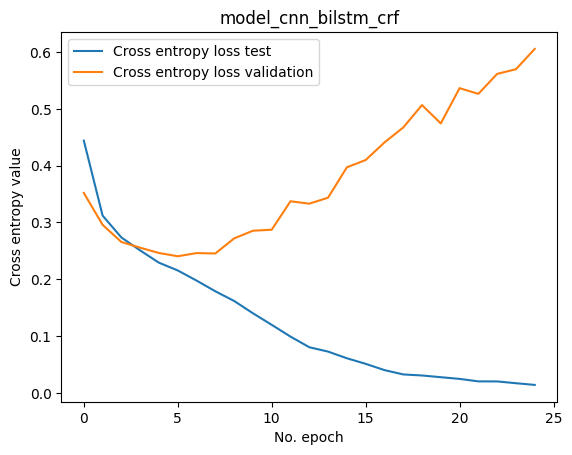

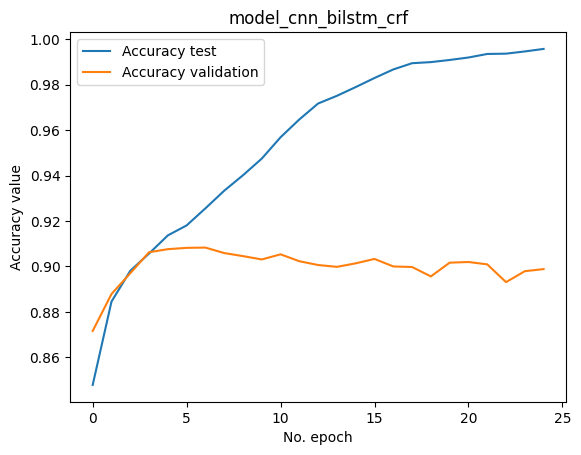

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


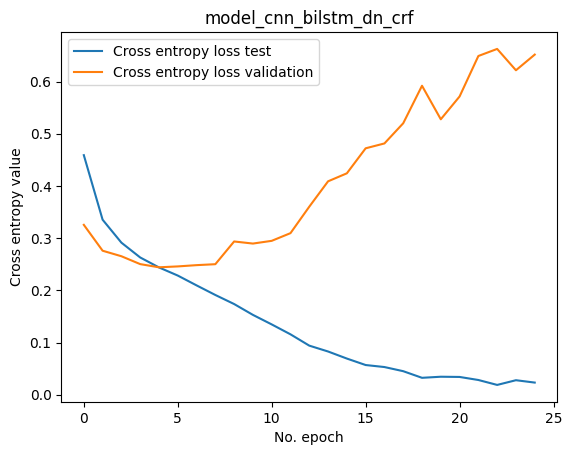

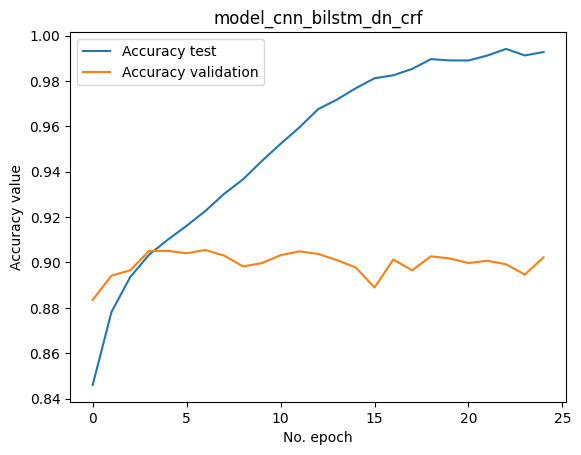

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


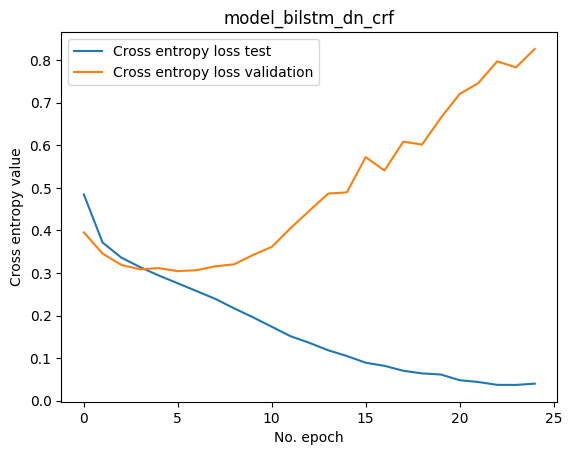

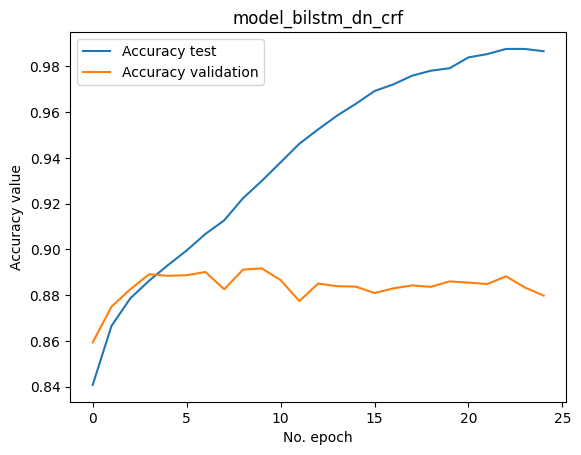

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


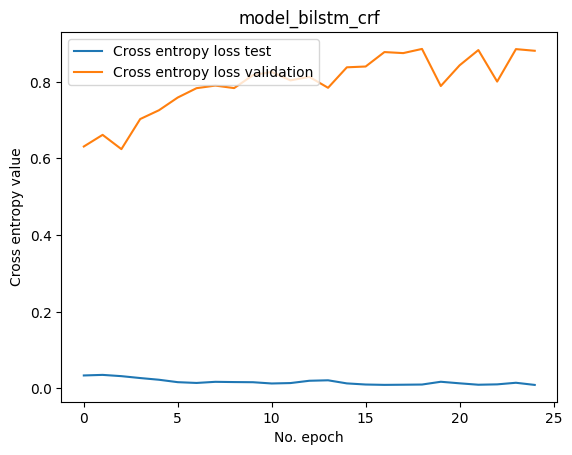

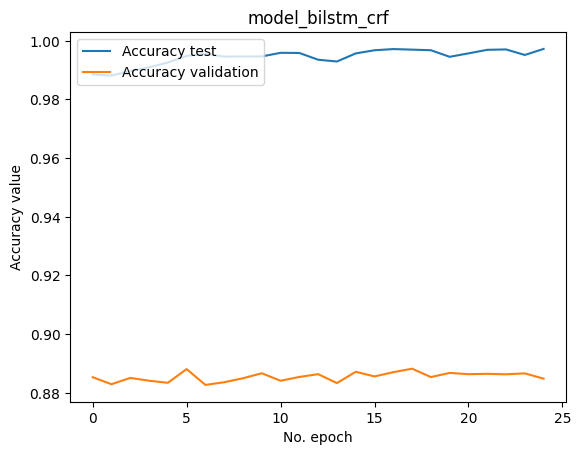

In [64]:
import matplotlib.pyplot as plt
def plot_history(title: str, path: Path):
    
    history = json.load(path.open())
    print(history.keys())
    
    plt.plot(history['loss'], label='Cross entropy loss train')
    plt.plot(history['val_loss'], label='Cross entropy loss validation')
    plt.title(title)
    plt.ylabel('Cross entropy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    
    plt.plot(history['acc'], label='Accuracy train')
    plt.plot(history['val_acc'], label='Accuracy validation')
    plt.title(title)
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

base_path = Path(params['model_histories_path'])

model_name = "model_cnn_bilstm_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_cnn_bilstm_dn_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_bilstm_dn_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")

model_name = "model_bilstm_crf"
plot_history(model_name, base_path / f"{model_name}_history.json")
